In [134]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [135]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [136]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [137]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [138]:
tf.keras.backend.clear_session()

In [139]:
subject = 'Distrito Federal - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [140]:
data = pd.read_csv('2003_mo_model_input_DF.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - Consumo de Cimento (t),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.826971,0.871928,50.047,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.827063,0.871678,48.110,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.827155,0.871428,49.006,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.827247,0.871178,48.445,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.827340,0.870928,51.436,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,2.285520,888.063858,1554.000510,22.107259,11.557766,54.920321,2.663202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,2.459765,887.482239,1504.599147,22.342946,12.632697,58.260143,2.597288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,2.404292,887.089138,1477.730987,22.495195,13.705746,61.921603,2.551755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,2.375765,887.036669,1469.367571,22.206488,14.859807,66.774435,2.510615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


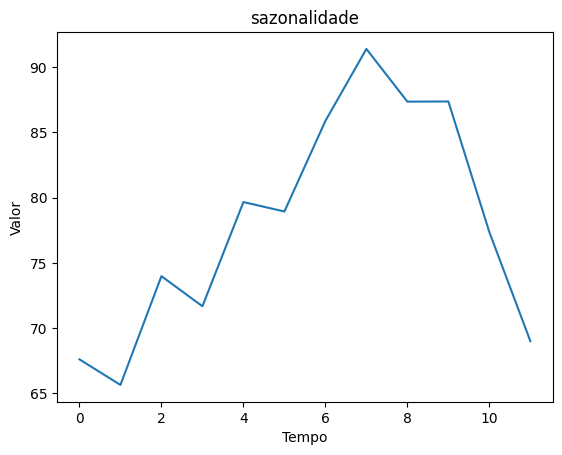

,sazonalidade
sazonalidade,
0,67.612260
1,65.651729
2,73.989587
3,71.679705
4,79.665749
5,78.942778
6,85.882160
7,91.401486
8,87.361027


In [141]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [142]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Distrito Federal - Consumo de Cimento (t)
0,2003-1,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.826971,0.871928,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,67.612260,50.047
1,2003-2,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.827063,0.871678,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,65.651729,48.110
2,2003-3,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.827155,0.871428,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,73.989587,49.006
3,2003-4,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.827247,0.871178,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,71.679705,48.445
4,2003-5,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.827340,0.870928,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,79.665749,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,2.285520,888.063858,1554.000510,22.107259,11.557766,54.920321,2.663202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.665749,NaN
269,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,2.459765,887.482239,1504.599147,22.342946,12.632697,58.260143,2.597288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.942778,NaN
270,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,2.404292,887.089138,1477.730987,22.495195,13.705746,61.921603,2.551755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.882160,NaN
271,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,2.375765,887.036669,1469.367571,22.206488,14.859807,66.774435,2.510615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [143]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
268       NaN
269       NaN
270       NaN
271       NaN
272       NaN
Name: Distrito Federal - Consumo de Cimento (t), Length: 273, dtype: float64

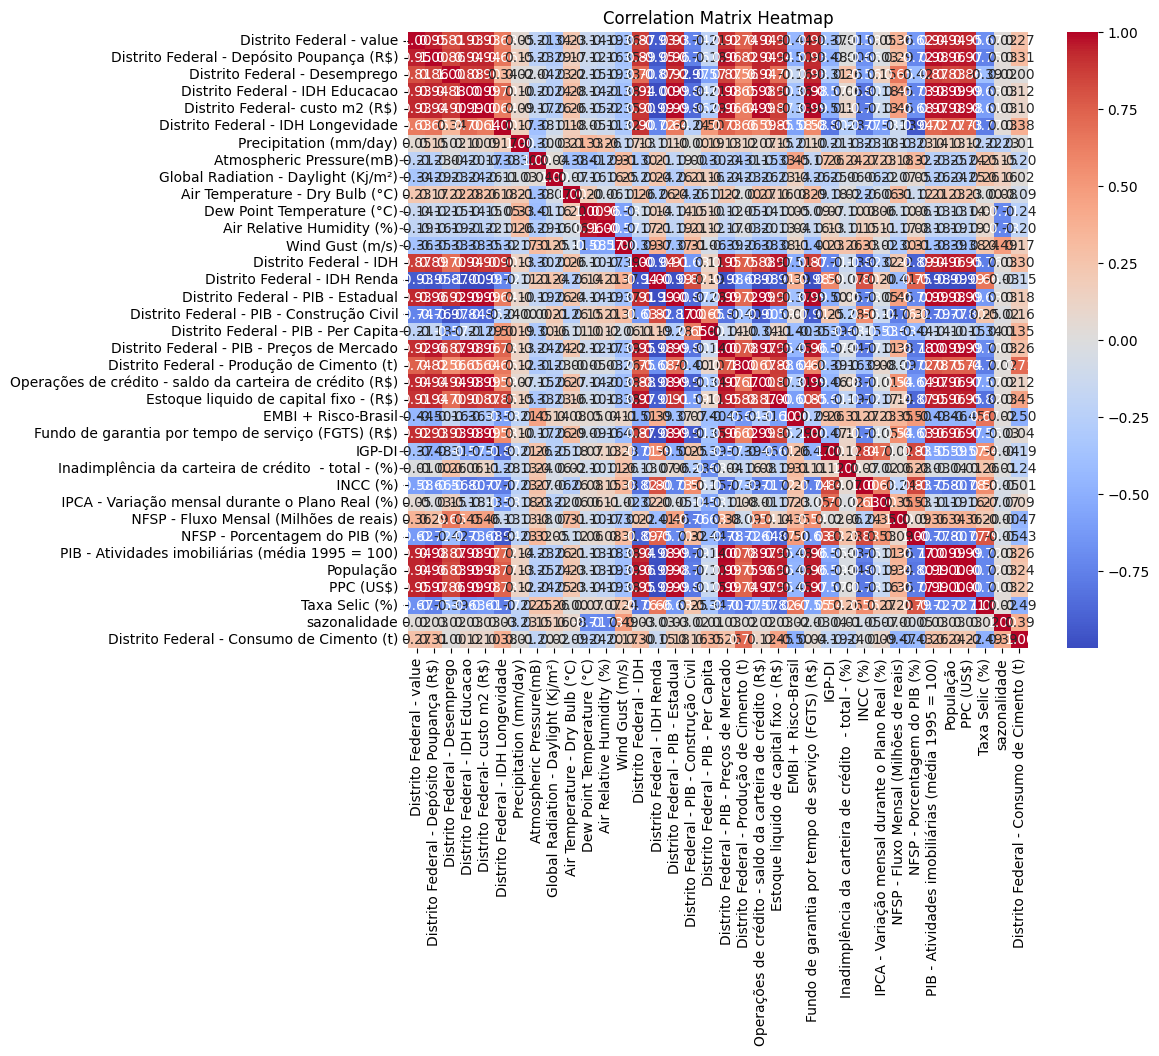

In [144]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [145]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [146]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Distrito Federal - value,2.327572e+03
1,Distrito Federal - Depósito Poupança (R$),5.635777e+03
2,Distrito Federal - Desemprego,1.339449e+03
3,Distrito Federal - IDH Educacao,4.692646e+08
4,Distrito Federal- custo m2 (R$),7.847041e+04
5,Distrito Federal - IDH Longevidade,1.170226e+04
6,Precipitation (mm/day),2.756871e+00
7,Atmospheric Pressure(mB),5.983175e+00
8,Global Radiation - Daylight (Kj/m²),3.414333e+00
9,Air Temperature - Dry Bulb (°C),3.853182e+01


In [147]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 8


,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.254227,4.896482e+06,8.293882,12173.796800,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,1.184017e+08,3.570616e+06,156.625720,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,67.612260
1,0.252655,4.934178e+06,8.287887,12272.096031,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,1.185511e+08,3.573184e+06,157.678528,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,65.651729
2,0.250972,4.971875e+06,8.281892,12362.351216,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,1.187006e+08,3.575752e+06,159.190268,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,73.989587
3,0.249179,5.009571e+06,8.275896,12449.345859,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,1.188500e+08,3.578320e+06,160.688376,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,71.679705
4,0.247070,5.047268e+06,8.269901,12543.454480,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,1.189994e+08,3.580889e+06,162.847410,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,79.665749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.334779,1.156156e+07,12.046727,26428.656725,2.038378,888.143976,1577.974265,21.737625,10.149648,52.455780,2.633363,1.414907e+08,3.440246e+06,227.223673,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,91.401486
176,0.335574,1.165433e+07,12.041170,26545.047959,1.898805,887.536151,1516.670149,21.849923,11.397912,56.539206,2.616464,1.414558e+08,3.442176e+06,225.662180,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,87.361027
177,0.336250,1.174710e+07,12.035612,26659.500688,2.188841,886.808366,1488.358687,22.046804,12.753491,60.788468,2.476332,1.414208e+08,3.444106e+06,224.312608,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,87.373797
178,0.337539,1.183987e+07,12.030054,26773.989818,2.511983,886.394548,1452.941466,21.734857,14.298075,66.911379,2.393259,1.413859e+08,3.446035e+06,222.710066,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,77.360064


In [148]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,-1.617445,-0.764190,-1.523235,0.335607,-0.111295,-0.289597,1.166714,1.170647,0.798911,0.469139,-1.638679,0.325878,-1.923354,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-1.256979
1,-1.600883,-0.767512,-1.500449,-0.035470,0.073548,-0.293832,0.615586,0.995119,0.740147,0.407585,-1.619603,0.361202,-1.900451,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.494353
2,-1.584321,-0.770833,-1.479527,-1.051528,0.284364,-0.313120,-0.081130,0.563065,0.488032,0.339364,-1.600527,0.396525,-1.867563,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-0.484835
3,-1.567760,-0.774155,-1.459361,-1.054920,0.715955,-0.279781,-0.965342,-0.186973,-0.049645,0.665348,-1.581451,0.431849,-1.834972,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-0.764507
4,-1.551198,-0.777476,-1.437546,-2.125593,0.886095,-0.277234,-1.427814,-0.862783,-0.608619,0.779575,-1.562375,0.467172,-1.788003,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,0.202414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.310814,1.314958,1.781145,-0.447140,0.368941,-0.204124,0.525957,-1.967664,-2.023151,1.174657,1.309231,-1.467255,-0.387516,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938,1.623334
176,1.351572,1.311879,1.808125,-0.881061,0.022643,-0.253698,0.717662,-1.296981,-1.406072,1.080995,1.304773,-1.440710,-0.421486,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688,1.134130
177,1.392330,1.308800,1.834656,0.020641,-0.392000,-0.276592,1.053758,-0.568639,-0.763932,0.304299,1.300315,-1.414165,-0.450846,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616,1.135676
178,1.433088,1.305721,1.861196,1.025268,-0.627766,-0.305232,0.521232,0.261254,0.161350,-0.156140,1.295857,-1.387621,-0.485708,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772,-0.076750


In [149]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,-1.617445,-0.764190,-1.523235,0.335607,-0.111295,-0.289597,1.166714,1.170647,0.798911,0.469139,-1.638679,0.325878,-1.923354,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-1.256979
1,-1.600883,-0.767512,-1.500449,-0.035470,0.073548,-0.293832,0.615586,0.995119,0.740147,0.407585,-1.619603,0.361202,-1.900451,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.494353
2,-1.584321,-0.770833,-1.479527,-1.051528,0.284364,-0.313120,-0.081130,0.563065,0.488032,0.339364,-1.600527,0.396525,-1.867563,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-0.484835
3,-1.567760,-0.774155,-1.459361,-1.054920,0.715955,-0.279781,-0.965342,-0.186973,-0.049645,0.665348,-1.581451,0.431849,-1.834972,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-0.764507
4,-1.551198,-0.777476,-1.437546,-2.125593,0.886095,-0.277234,-1.427814,-0.862783,-0.608619,0.779575,-1.562375,0.467172,-1.788003,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,0.202414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.862081,1.371868,1.460933,2.028477,0.264091,-0.251700,1.361434,-1.038271,-1.509341,-0.112974,1.334471,-1.628027,-0.137790,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090,1.623334
164,0.894766,1.364797,1.487879,2.833359,-0.063284,-0.259906,1.590333,-0.498342,-1.029133,-0.019103,1.335664,-1.633035,-0.150045,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875,1.134130
165,0.927451,1.357725,1.515110,1.056407,-0.331861,-0.278192,1.407161,0.120692,-0.376034,-0.469287,1.336857,-1.638043,-0.166182,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030,1.135676
166,0.960136,1.350654,1.542377,1.246795,-0.454902,-0.301368,0.988400,0.572338,0.226629,-0.620668,1.338051,-1.643051,-0.194921,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803,-0.076750


In [150]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
163    58.854
164    53.940
165    51.514
166    42.635
167    40.371
Name: Distrito Federal - Consumo de Cimento (t), Length: 168, dtype: float64

In [151]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [152]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 26)

In [153]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
132,1.354924,1.178149,0.767843,1.477494,-0.634535,-0.270168,0.302107,1.070817,1.041358,-0.553595,1.025607,-0.965888,1.373328,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376,-1.256979
133,1.316790,1.191719,0.790085,0.421765,-0.552678,-0.294140,-0.121739,1.000368,1.084450,-1.015597,1.041004,-1.010214,1.336965,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859,-1.494353
134,1.278657,1.205289,0.813023,0.469836,-0.253711,-0.314992,-0.759027,0.771239,1.025580,-1.715691,1.056402,-1.054540,1.291634,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952,-0.484835
135,1.240523,1.218858,0.835930,0.208351,0.178884,-0.303841,-1.432230,0.154208,0.532463,-2.019666,1.071799,-1.098866,1.244049,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200,-0.764507
136,1.202389,1.232428,0.858940,-0.272620,0.492361,-0.283202,-1.743833,-0.794845,-0.353825,-2.029491,1.087196,-1.143191,1.194731,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944,0.202414
137,1.164256,1.245997,0.881745,0.037688,0.624548,-0.248236,-1.127841,-1.339464,-1.042858,-1.580874,1.102594,-1.187517,1.143680,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692,0.114879
138,1.126122,1.259567,0.904100,0.493031,0.572214,-0.208007,-0.202773,-1.764827,-1.663132,-0.863934,1.117991,-1.231843,1.091101,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126,0.955074
139,1.087989,1.273137,0.921394,0.577176,0.187668,-0.206862,0.645239,-1.511860,-1.604206,-0.661169,1.133389,-1.276169,1.037140,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065,1.623334
140,1.049855,1.286706,0.940402,0.520028,-0.133725,-0.247004,0.966573,-0.819545,-0.957631,-0.376511,1.148786,-1.320494,0.981966,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206,1.134130
141,1.011722,1.300276,0.959335,1.672320,-0.284451,-0.246707,1.097439,-0.331743,-0.517153,-0.664036,1.164184,-1.364820,0.925910,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794,1.135676


In [154]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 26)

In [155]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells,
               third_layer_n_cells,
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=(second_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    
    if second_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(
            second_layer_n_cells,
            activation='tanh',
            return_sequences=(second_layer_n_cells > 0 and third_layer_n_cells > 0),
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    if second_layer_n_cells > 0 and third_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.LSTM(
            third_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.07,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [156]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells, third_layer_n_cells):
                    
    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(2)]

    best_loss = float('inf')
    winner_seed = None
    
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells, third_layer_n_cells,
                                    want_verbose=0, seed=seed)
        
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")
        
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, best_loss

    return winner_seed, best_loss

In [157]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [0, 36, 72, 144]
third_layer_cells_list = [0, 36, 72, 144]

In [158]:
def hyperparameter_tuning(train_input, train_target, 
                          first_layer_cells_list, second_layer_cells_list, third_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            for third_cells in third_layer_cells_list:
                if not third_cells > second_cells:
                    print(f"_________________________________________________________________________________________")
                    print(" ")
                    print(f" Testing [{first_cells}, {second_cells}, {third_cells}]")
                    print(f"_________________________________________________________________________________________")

                    winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                                first_cells, second_cells, third_cells)
                    print(" ")
                    print(f"first_layer_n_cells: {first_cells}")
                    print(f"second_layer_n_cells: {second_cells}")
                    print(f"third_layer_n_cells: {third_cells}")
                    if mean_loss < best_loss:
                        best_loss = mean_loss
                        best_combination = [first_cells, second_cells, third_cells, winner_seed]
                        print(f"best_loss: {best_loss}")
                        print(f"winner_seed: {winner_seed}")
                    print(" ")
            
    return best_combination

In [159]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list, 
                                         third_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
 Testing [36, 0, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 43.8039665222168
winner_seed: 1276251358


Step: 1 ___________________________________________
val_loss: 47.60531234741211
 
first_layer_n_cells: 36
second_layer_n_cells: 0
third_layer_n_cells: 0
best_loss: 43.8039665222168
winner_seed: 1276251358
 
_________________________________________________________________________________________
 
 Testing [36, 36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 17.832616806030273
winner_seed: 2603382586


Step: 1 ___________________________________________
val_loss: 25.255084991455078
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 0
best_loss: 17.832

val_loss: 30.17730712890625
winner_seed: 3571834197


Step: 1 ___________________________________________
val_loss: 23.542007446289062
winner_seed: 1464908109
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 36
 
_________________________________________________________________________________________
 
 Testing [72, 144, 72]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 16.95376968383789
winner_seed: 3550163262


Step: 1 ___________________________________________
val_loss: 24.954233169555664
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 72
 
_________________________________________________________________________________________
 
 Testing [72, 144, 144]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 25.857534408569336
wi

[72, 72, 36, 1810440749]

In [160]:
best_combination

[72, 72, 36, 1810440749]

In [161]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], best_combination[2],
                                    want_verbose=1, 
                                    seed=best_combination[3])

Epoch 1/10000
4/4 [==============================] - 4s 184ms/step - loss: 6925.4263 - val_loss: 2004.1057
Epoch 2/10000
4/4 [==============================] - 0s 13ms/step - loss: 6243.6538 - val_loss: 1683.1101
Epoch 3/10000
4/4 [==============================] - 0s 12ms/step - loss: 5861.0962 - val_loss: 1533.4912
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 5654.2637 - val_loss: 1458.4421
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 5526.9355 - val_loss: 1398.5481
Epoch 6/10000
4/4 [==============================] - 0s 13ms/step - loss: 5415.4551 - val_loss: 1341.6001
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 5306.7432 - val_loss: 1286.3016
Epoch 8/10000
4/4 [==============================] - 0s 13ms/step - loss: 5199.3687 - val_loss: 1232.6761
Epoch 9/10000
4/4 [==============================] - 0s 13ms/step - loss: 5095.7837 - val_loss: 1180.5468
Epoch 10/10000
4/4 [=========================

4/4 [==============================] - 0s 14ms/step - loss: 1265.2113 - val_loss: 86.6230
Epoch 79/10000
4/4 [==============================] - 0s 12ms/step - loss: 1240.8960 - val_loss: 92.0478
Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 1218.1511 - val_loss: 97.7535
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 1197.4042 - val_loss: 103.8826
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 1175.1965 - val_loss: 110.1957
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 1154.9979 - val_loss: 116.8559
Epoch 84/10000
4/4 [==============================] - 0s 12ms/step - loss: 1134.1108 - val_loss: 123.6814
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 1113.7103 - val_loss: 130.6733
Epoch 86/10000
4/4 [==============================] - 0s 13ms/step - loss: 1094.6608 - val_loss: 137.9221
Epoch 87/10000
4/4 [==============================] - 0s 12ms/st

4/4 [==============================] - 0s 12ms/step - loss: 547.9541 - val_loss: 790.8063
Epoch 156/10000
4/4 [==============================] - 0s 11ms/step - loss: 546.1390 - val_loss: 798.6912
Epoch 157/10000
4/4 [==============================] - 0s 12ms/step - loss: 544.2906 - val_loss: 806.3770
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 542.7679 - val_loss: 814.2732
Epoch 159/10000
4/4 [==============================] - 0s 12ms/step - loss: 540.9445 - val_loss: 821.7362
Epoch 160/10000
4/4 [==============================] - 0s 11ms/step - loss: 539.3357 - val_loss: 829.0012
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 537.8859 - val_loss: 836.2880
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 536.4446 - val_loss: 843.5052
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 535.1522 - val_loss: 850.7082
Epoch 164/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 12ms/step - loss: 506.2097 - val_loss: 1119.1906
Epoch 233/10000
4/4 [==============================] - 0s 12ms/step - loss: 506.2055 - val_loss: 1121.5073
Epoch 234/10000
4/4 [==============================] - 0s 12ms/step - loss: 506.0927 - val_loss: 1123.0033
Epoch 235/10000
4/4 [==============================] - 0s 10ms/step - loss: 506.0530 - val_loss: 1124.8883
Epoch 236/10000
4/4 [==============================] - 0s 12ms/step - loss: 506.0417 - val_loss: 1127.1906
Epoch 237/10000
4/4 [==============================] - 0s 11ms/step - loss: 505.9474 - val_loss: 1128.7927
Epoch 238/10000
4/4 [==============================] - 0s 11ms/step - loss: 505.8863 - val_loss: 1130.1373
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 505.8227 - val_loss: 1131.2823
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 505.7891 - val_loss: 1132.4711
Epoch 241/10000
4/4 [==============================] 

4/4 [==============================] - 0s 13ms/step - loss: 203.8273 - val_loss: 189.0298
Epoch 310/10000
4/4 [==============================] - 0s 12ms/step - loss: 202.9509 - val_loss: 191.1197
Epoch 311/10000
4/4 [==============================] - 0s 12ms/step - loss: 201.2379 - val_loss: 193.7208
Epoch 312/10000
4/4 [==============================] - 0s 12ms/step - loss: 198.6538 - val_loss: 196.2078
Epoch 313/10000
4/4 [==============================] - 0s 12ms/step - loss: 199.5119 - val_loss: 197.4589
Epoch 314/10000
4/4 [==============================] - 0s 13ms/step - loss: 198.0802 - val_loss: 197.5795
Epoch 315/10000
4/4 [==============================] - 0s 14ms/step - loss: 196.3713 - val_loss: 198.4284
Epoch 316/10000
4/4 [==============================] - 0s 13ms/step - loss: 196.9009 - val_loss: 199.9589
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 194.7243 - val_loss: 200.8610
Epoch 318/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 12ms/step - loss: 69.2425 - val_loss: 30.1666
Epoch 388/10000
4/4 [==============================] - 0s 13ms/step - loss: 72.0619 - val_loss: 38.4665
Epoch 389/10000
4/4 [==============================] - 0s 14ms/step - loss: 71.1483 - val_loss: 47.8542
Epoch 390/10000
4/4 [==============================] - 0s 12ms/step - loss: 71.0852 - val_loss: 39.1200
Epoch 391/10000
4/4 [==============================] - 0s 13ms/step - loss: 70.1926 - val_loss: 37.1922
Epoch 392/10000
4/4 [==============================] - 0s 14ms/step - loss: 66.4388 - val_loss: 36.8546
Epoch 393/10000
4/4 [==============================] - 0s 13ms/step - loss: 67.5948 - val_loss: 37.7563
Epoch 394/10000
4/4 [==============================] - 0s 10ms/step - loss: 64.1631 - val_loss: 40.0076
Epoch 395/10000
4/4 [==============================] - 0s 11ms/step - loss: 66.2988 - val_loss: 32.8039
Epoch 396/10000
4/4 [==============================] - 0s 11ms/step - loss: 66.4

Epoch 466/10000
4/4 [==============================] - 0s 12ms/step - loss: 42.2504 - val_loss: 36.1545
Epoch 467/10000
4/4 [==============================] - 0s 12ms/step - loss: 43.3446 - val_loss: 36.2420
Epoch 468/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.9650 - val_loss: 38.9895
Epoch 469/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.4205 - val_loss: 45.8902
Epoch 470/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.6757 - val_loss: 45.7927
Epoch 471/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.7816 - val_loss: 42.2049
Epoch 472/10000
4/4 [==============================] - 0s 12ms/step - loss: 41.2973 - val_loss: 46.8626
Epoch 473/10000
4/4 [==============================] - 0s 12ms/step - loss: 40.1668 - val_loss: 41.9122
Epoch 474/10000
4/4 [==============================] - 0s 13ms/step - loss: 41.6851 - val_loss: 33.5569
Epoch 475/10000
4/4 [==============================] - 0s 13ms/s

Epoch 545/10000
4/4 [==============================] - 0s 12ms/step - loss: 29.6506 - val_loss: 39.7671
Epoch 546/10000
4/4 [==============================] - 0s 12ms/step - loss: 30.6128 - val_loss: 25.6392
Epoch 547/10000
4/4 [==============================] - 0s 12ms/step - loss: 31.4477 - val_loss: 46.0772
Epoch 548/10000
4/4 [==============================] - 0s 13ms/step - loss: 29.4739 - val_loss: 52.2929
Epoch 549/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.3624 - val_loss: 54.6479
Epoch 550/10000
4/4 [==============================] - 0s 12ms/step - loss: 32.0877 - val_loss: 53.2950
Epoch 551/10000
4/4 [==============================] - 0s 13ms/step - loss: 29.2435 - val_loss: 38.9749
Epoch 552/10000
4/4 [==============================] - 0s 15ms/step - loss: 30.9593 - val_loss: 40.1755
Epoch 553/10000
4/4 [==============================] - 0s 13ms/step - loss: 28.2274 - val_loss: 45.8779
Epoch 554/10000
4/4 [==============================] - 0s 13ms/s

Epoch 624/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.6723 - val_loss: 54.0463
Epoch 625/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.1505 - val_loss: 58.3280
Epoch 626/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.0228 - val_loss: 33.7699
Epoch 627/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.8902 - val_loss: 39.8524
Epoch 628/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.3939 - val_loss: 60.0351
Epoch 629/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.4404 - val_loss: 48.2320
Epoch 630/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.0211 - val_loss: 31.8553
Epoch 631/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.5036 - val_loss: 29.7330
Epoch 632/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.6156 - val_loss: 40.0743
Epoch 633/10000
4/4 [==============================] - 0s 12ms/s

Epoch 703/10000
4/4 [==============================] - 0s 13ms/step - loss: 17.5975 - val_loss: 56.8855
Epoch 704/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.6943 - val_loss: 60.5363
Epoch 705/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.4566 - val_loss: 53.6480
Epoch 706/10000
4/4 [==============================] - 0s 13ms/step - loss: 17.8519 - val_loss: 41.4916
Epoch 707/10000
4/4 [==============================] - 0s 13ms/step - loss: 17.1768 - val_loss: 39.3974
Epoch 708/10000
4/4 [==============================] - 0s 14ms/step - loss: 18.1447 - val_loss: 42.7100
Epoch 709/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.8145 - val_loss: 59.2211
Epoch 710/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.9966 - val_loss: 46.5971
Epoch 711/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.4412 - val_loss: 42.7238
Epoch 712/10000
4/4 [==============================] - 0s 12ms/s

Epoch 782/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.1068 - val_loss: 42.4557
Epoch 783/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.9691 - val_loss: 35.8297
Epoch 784/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.1736 - val_loss: 46.3247
Epoch 785/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.0437 - val_loss: 53.8039
Epoch 786/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.0152 - val_loss: 54.9359
Epoch 787/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.2281 - val_loss: 42.9368
Epoch 788/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.3461 - val_loss: 40.8777
Epoch 789/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.9984 - val_loss: 68.4701
Epoch 790/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.8346 - val_loss: 60.7526
Epoch 791/10000
4/4 [==============================] - 0s 9ms/step

4/4 [==============================] - 0s 10ms/step - loss: 11.5429 - val_loss: 50.4015
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.5926 - val_loss: 41.7913
Epoch 863/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.8262 - val_loss: 52.2800
Epoch 864/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.0785 - val_loss: 46.3636
Epoch 865/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.9031 - val_loss: 52.8063
Epoch 866/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.4957 - val_loss: 38.1494
Epoch 867/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.1740 - val_loss: 39.4961
Epoch 868/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.7079 - val_loss: 44.5383
Epoch 869/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.2576 - val_loss: 51.0530
Epoch 870/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.9365 

4/4 [==============================] - 0s 12ms/step - loss: 9.4060 - val_loss: 22.5634
Epoch 941/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.4444 - val_loss: 22.7453
Epoch 942/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.1198 - val_loss: 28.5380
Epoch 943/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.6587 - val_loss: 24.3710
Epoch 944/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.1892 - val_loss: 22.8578
Epoch 945/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.9327 - val_loss: 27.3334
Epoch 946/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.6090 - val_loss: 26.0253
Epoch 947/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.4692 - val_loss: 30.3121
Epoch 948/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.4658 - val_loss: 35.1146
Epoch 949/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.1035 - va

4/4 [==============================] - 0s 11ms/step - loss: 8.7684 - val_loss: 36.4134
Epoch 1020/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4617 - val_loss: 25.4085
Epoch 1021/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4423 - val_loss: 28.3135
Epoch 1022/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.3531 - val_loss: 25.8903
Epoch 1023/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6904 - val_loss: 29.7466
Epoch 1024/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.6798 - val_loss: 21.4104
Epoch 1025/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.7641 - val_loss: 25.9829
Epoch 1026/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.8210 - val_loss: 29.0163
Epoch 1027/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.4636 - val_loss: 28.5667
Epoch 1028/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.6

Epoch 1098/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1618 - val_loss: 27.0758
Epoch 1099/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.0274 - val_loss: 28.7799
Epoch 1100/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6724 - val_loss: 21.5603
Epoch 1101/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.3643 - val_loss: 28.2469
Epoch 1102/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.7097 - val_loss: 24.9769
Epoch 1103/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.9475 - val_loss: 27.9071
Epoch 1104/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.9133 - val_loss: 26.2831
Epoch 1105/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.2680 - val_loss: 29.4922
Epoch 1106/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.8325 - val_loss: 22.9933
Epoch 1107/10000
4/4 [==============================] - 0s 12ms

Epoch 1177/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.7105 - val_loss: 29.5462
Epoch 1178/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.7592 - val_loss: 22.8855
Epoch 1179/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.3404 - val_loss: 30.6776
Epoch 1180/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9289 - val_loss: 32.6191
Epoch 1181/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.6763 - val_loss: 26.5605
Epoch 1182/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.6505 - val_loss: 30.3484
Epoch 1183/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1935 - val_loss: 29.4955
Epoch 1184/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5220 - val_loss: 25.5294
Epoch 1185/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.1479 - val_loss: 28.5471
Epoch 1186/10000
4/4 [==============================] - 0s 11ms/

Epoch 1256/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.5231 - val_loss: 27.7612
Epoch 1257/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.6834 - val_loss: 27.0916
Epoch 1258/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.3077 - val_loss: 29.1460
Epoch 1259/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.3966 - val_loss: 33.2242
Epoch 1260/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8331 - val_loss: 29.7087
Epoch 1261/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.1517 - val_loss: 26.6015
Epoch 1262/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.4863 - val_loss: 32.4374
Epoch 1263/10000
4/4 [==============================] - 0s 15ms/step - loss: 6.5410 - val_loss: 27.8718
Epoch 1264/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.9093 - val_loss: 36.5516
Epoch 1265/10000
4/4 [==============================] - 0s 14ms/

4/4 [==============================] - 0s 13ms/step - loss: 7.7901 - val_loss: 28.7354
Epoch 1335/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3534 - val_loss: 23.9882
Epoch 1336/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9690 - val_loss: 29.5032
Epoch 1337/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.1679 - val_loss: 29.0040
Epoch 1338/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.4401 - val_loss: 26.8311
Epoch 1339/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.1131 - val_loss: 36.8403
Epoch 1340/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.7570 - val_loss: 22.5996
Epoch 1341/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.9927 - val_loss: 24.1944
Epoch 1342/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.4088 - val_loss: 31.0675
Epoch 1343/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.57

Epoch 1413/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.9495 - val_loss: 19.5242
Epoch 1414/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.8455 - val_loss: 23.2206
Epoch 1415/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.3474 - val_loss: 24.5273
Epoch 1416/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.2890 - val_loss: 18.1726
Epoch 1417/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5548 - val_loss: 25.0129
Epoch 1418/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.3633 - val_loss: 24.8222
Epoch 1419/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.3274 - val_loss: 19.6347
Epoch 1420/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.1121 - val_loss: 28.6383
Epoch 1421/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.6849 - val_loss: 23.4400
Epoch 1422/10000
4/4 [==============================] - 0s 13ms/

Epoch 1492/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5006 - val_loss: 17.7781
Epoch 1493/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.3859 - val_loss: 21.0793
Epoch 1494/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.6781 - val_loss: 18.9157
Epoch 1495/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.0627 - val_loss: 30.2716
Epoch 1496/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.5389 - val_loss: 24.5793
Epoch 1497/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.4724 - val_loss: 20.4989
Epoch 1498/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.6991 - val_loss: 23.3777
Epoch 1499/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.2130 - val_loss: 26.7867
Epoch 1500/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.4258 - val_loss: 22.7077
Epoch 1501/10000
4/4 [==============================] - 0s 14ms/

Epoch 1571/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.6834 - val_loss: 26.8807
Epoch 1572/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.4510 - val_loss: 23.0892
Epoch 1573/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.0380 - val_loss: 32.6935
Epoch 1574/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.6415 - val_loss: 27.4611
Epoch 1575/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.3274 - val_loss: 26.7448
Epoch 1576/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.2537 - val_loss: 25.8888
Epoch 1577/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.5542 - val_loss: 31.7202
Epoch 1578/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.6753 - val_loss: 22.8235
Epoch 1579/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.0490 - val_loss: 24.0362
Epoch 1580/10000
4/4 [==============================] - 0s 14ms/

Epoch 1650/10000
4/4 [==============================] - 0s 15ms/step - loss: 39.8345 - val_loss: 6059.3950
Epoch 1651/10000
4/4 [==============================] - 0s 14ms/step - loss: 401.1816 - val_loss: 93.7654
Epoch 1652/10000
4/4 [==============================] - 0s 14ms/step - loss: 56.5525 - val_loss: 59.5767
Epoch 1653/10000
4/4 [==============================] - 0s 14ms/step - loss: 44.1980 - val_loss: 51.1819
Epoch 1654/10000
4/4 [==============================] - 0s 15ms/step - loss: 98.3750 - val_loss: 51.8830
Epoch 1655/10000
4/4 [==============================] - 0s 15ms/step - loss: 45.3118 - val_loss: 52.8818
Epoch 1656/10000
4/4 [==============================] - 0s 14ms/step - loss: 69.7880 - val_loss: 53.7680
Epoch 1657/10000
4/4 [==============================] - 0s 13ms/step - loss: 74.6723 - val_loss: 55.0343
Epoch 1658/10000
4/4 [==============================] - 0s 13ms/step - loss: 75.0184 - val_loss: 57.1823
Epoch 1659/10000
4/4 [==============================

Epoch 1728/10000
4/4 [==============================] - 0s 13ms/step - loss: 30.5861 - val_loss: 72.8346
Epoch 1729/10000
4/4 [==============================] - 0s 13ms/step - loss: 30.3444 - val_loss: 72.9034
Epoch 1730/10000
4/4 [==============================] - 0s 13ms/step - loss: 30.5103 - val_loss: 72.5846
Epoch 1731/10000
4/4 [==============================] - 0s 14ms/step - loss: 30.1310 - val_loss: 72.4055
Epoch 1732/10000
4/4 [==============================] - 0s 14ms/step - loss: 31.2176 - val_loss: 72.4505
Epoch 1733/10000
4/4 [==============================] - 0s 13ms/step - loss: 30.6194 - val_loss: 72.3858
Epoch 1734/10000
4/4 [==============================] - 0s 13ms/step - loss: 31.3770 - val_loss: 72.2375
Epoch 1735/10000
4/4 [==============================] - 0s 14ms/step - loss: 30.0603 - val_loss: 72.3819
Epoch 1736/10000
4/4 [==============================] - 0s 14ms/step - loss: 31.2390 - val_loss: 72.0551
Epoch 1737/10000
4/4 [==============================] -

4/4 [==============================] - 0s 14ms/step - loss: 27.6398 - val_loss: 68.7972
Epoch 1807/10000
4/4 [==============================] - 0s 14ms/step - loss: 27.9322 - val_loss: 68.9079
Epoch 1808/10000
4/4 [==============================] - 0s 13ms/step - loss: 27.6719 - val_loss: 68.9844
Epoch 1809/10000
4/4 [==============================] - 0s 14ms/step - loss: 27.7438 - val_loss: 69.1263
Epoch 1810/10000
4/4 [==============================] - 0s 14ms/step - loss: 27.2978 - val_loss: 69.1560
Epoch 1811/10000
4/4 [==============================] - 0s 14ms/step - loss: 27.1398 - val_loss: 69.0045
Epoch 1812/10000
4/4 [==============================] - 0s 14ms/step - loss: 26.9858 - val_loss: 68.9012
Epoch 1813/10000
4/4 [==============================] - 0s 13ms/step - loss: 27.2283 - val_loss: 68.9063
Epoch 1814/10000
4/4 [==============================] - 0s 13ms/step - loss: 27.6032 - val_loss: 69.1152
Epoch 1815/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 23.0064 - val_loss: 70.6202
Epoch 1885/10000
4/4 [==============================] - 0s 13ms/step - loss: 23.6782 - val_loss: 68.8284
Epoch 1886/10000
4/4 [==============================] - 0s 13ms/step - loss: 23.0146 - val_loss: 66.3785
Epoch 1887/10000
4/4 [==============================] - 0s 14ms/step - loss: 22.3899 - val_loss: 74.4843
Epoch 1888/10000
4/4 [==============================] - 0s 13ms/step - loss: 22.1373 - val_loss: 71.8391
Epoch 1889/10000
4/4 [==============================] - 0s 14ms/step - loss: 22.3670 - val_loss: 67.6888
Epoch 1890/10000
4/4 [==============================] - 0s 14ms/step - loss: 21.6969 - val_loss: 64.1932
Epoch 1891/10000
4/4 [==============================] - 0s 14ms/step - loss: 21.9206 - val_loss: 64.3382
Epoch 1892/10000
4/4 [==============================] - 0s 15ms/step - loss: 20.9897 - val_loss: 61.0374
Epoch 1893/10000
4/4 [==============================] - 0s 15ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 12.7365 - val_loss: 26.6202
Epoch 1963/10000
4/4 [==============================] - 0s 14ms/step - loss: 11.2071 - val_loss: 26.3738
Epoch 1964/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.0184 - val_loss: 24.4569
Epoch 1965/10000
4/4 [==============================] - 0s 14ms/step - loss: 11.0930 - val_loss: 26.3455
Epoch 1966/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.7006 - val_loss: 24.0338
Epoch 1967/10000
4/4 [==============================] - 0s 14ms/step - loss: 11.7209 - val_loss: 31.1833
Epoch 1968/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.2442 - val_loss: 25.1853
Epoch 1969/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.4021 - val_loss: 27.7563
Epoch 1970/10000
4/4 [==============================] - 0s 14ms/step - loss: 10.3304 - val_loss: 30.4521
Epoch 1971/10000
4/4 [==============================] - 0s 14ms/step - l

Epoch 2041/10000
4/4 [==============================] - 0s 14ms/step - loss: 7.9579 - val_loss: 25.2680
Epoch 2042/10000
4/4 [==============================] - 0s 14ms/step - loss: 7.8900 - val_loss: 26.2575
Epoch 2043/10000
4/4 [==============================] - 0s 16ms/step - loss: 8.1116 - val_loss: 25.6924
Epoch 2043: early stopping


In [162]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [163]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,46.9049,41.88995,46.114754,48.116104,47.816917,52.894615,55.680775,59.219978,59.047386,57.272514,51.908859,44.19265
Target,48.99,44.726,44.491,43.901,55.019,50.942,63.992,64.127,60.822,65.182,51.282,43.554
Error,2.085102,2.836052,1.623753,4.215103,7.202084,1.952614,8.311226,4.907021,1.774612,7.909485,0.626858,0.638649


In [164]:
display(mae)
display(mape)

3.6735466

0.06596013